In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import display

from textdefendr.utils.file_io import load_json
from textdefendr.utils.notebook import (
    CMAP,
    columns_order_to_sort,
    display_tables,
    extract_infos,
    plot_confusion_matrix_serie,
    remove_columns,
    scatter_plot,
    select_experiment,
)

pd.set_option("display.max_columns", None)

In [3]:
all_experiments_dir = Path("data_tcab/detection-experiments/")

df_list = []
for metrics_path in all_experiments_dir.glob("**/metrics.json"):
    # print(metrics_path)
    infos = extract_infos(metrics_path)
    metrics = load_json(metrics_path)
    infos.update(metrics)
    df_list.append(infos)

df = pd.DataFrame(df_list)

In [4]:
for column in df.columns:
    if "confusion_matrix" in column:
        df[column] = df[column].apply(lambda x: np.array(x))

df = df[df.setting == "clean_vs_all"]
df = remove_columns(df, ["train", "test", "balanced"])

In [5]:
df.sample(3)

,target_dataset,target_model,embeddings,setting,classification_model,feature_setting,is_binary,validation_accuracy,validation_confusion_matrix,validation_recall,validation_precision,validation_f1_score,validation_roc_auc,best_params,classes_labels,important_features,feature_names,coef,intercept
3,allocine,distilcamembert,default,clean_vs_all,LGB,bert+tp+lm,True,0.787964,"[[1533, 245], [509, 1269]]",0.713723,0.838177,0.770960,0.787964,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...","[clean, perturbed]",None,"[lm_perplexity_region0, lm_perplexity_region1,...",None,None
1,allocine,distilcamembert,default,clean_vs_all,LGB,bert,True,0.660574,"[[1372, 406], [801, 977]]",0.549494,0.706435,0.618159,0.660574,"{'lgbmclassifier__boosting_type': 'gbdt', 'lgb...","[clean, perturbed]",None,"[lm_bert_0, lm_bert_1, lm_bert_2, lm_bert_3, l...",None,None
9,allocine,distilcamembert,default,clean_vs_all,RF,bert,True,0.622047,"[[1248, 530], [814, 964]]",0.542182,0.645248,0.589242,0.622047,"{'randomforestclassifier__max_depth': 5, 'rand...","[clean, perturbed]",None,"[lm_bert_0, lm_bert_1, lm_bert_2, lm_bert_3, l...",None,None


In [6]:
df.columns

Index(['target_dataset', 'target_model', 'embeddings', 'setting',
       'classification_model', 'feature_setting', 'is_binary',
       'validation_accuracy', 'validation_confusion_matrix',
       'validation_recall', 'validation_precision', 'validation_f1_score',
       'validation_roc_auc', 'best_params', 'classes_labels',
       'important_features', 'feature_names', 'coef', 'intercept'],
      dtype='object')

In [7]:
COLUMNS_ORDER = {
    "embeddings": ["default", "fr+small"],
    "feature_setting": ["bert", "bert+tp", "bert+tp+lm", "all"],
    "classification_model": ["LR", "RF", "LGB"],
}
COLUMNS_KEY = columns_order_to_sort(COLUMNS_ORDER)

## Table

In [8]:
display_tables(
    df, COLUMNS_ORDER, COLUMNS_KEY, transpose=False, sort_metric="validation_accuracy"
)

,validation_accuracy,validation_recall,validation_precision,validation_f1_score,validation_roc_auc
embeddings,,,,,
fr+small,0.845215,0.813320,0.867397,0.838480,0.845215
default,0.774817,0.713301,0.805408,0.754821,0.774817


,validation_accuracy,validation_recall,validation_precision,validation_f1_score,validation_roc_auc
feature_setting,,,,,
all,0.945726,0.953693,0.939337,0.946193,0.945726
bert+tp+lm,0.808727,0.748313,0.850563,0.795894,0.808727
bert+tp,0.755062,0.685696,0.793913,0.734867,0.755062
bert,0.730549,0.665542,0.761796,0.709646,0.730549


,validation_accuracy,validation_recall,validation_precision,validation_f1_score,validation_roc_auc
classification_model,,,,,
LR,0.829935,0.790284,0.854576,0.820621,0.829935
LGB,0.818441,0.760124,0.853654,0.802227,0.818441
RF,0.781672,0.739525,0.800977,0.767103,0.781672


In [9]:
display_tables(df, COLUMNS_ORDER, COLUMNS_KEY, transpose=True)

embeddings,default,fr+small
feature,,
validation_accuracy,0.774817,0.845215
validation_recall,0.713301,0.813320
validation_precision,0.805408,0.867397
validation_f1_score,0.754821,0.838480
validation_roc_auc,0.774817,0.845215


feature_setting,bert,bert+tp,bert+tp+lm,all
feature,,,,
validation_accuracy,0.730549,0.755062,0.808727,0.945726
validation_recall,0.665542,0.685696,0.748313,0.953693
validation_precision,0.761796,0.793913,0.850563,0.939337
validation_f1_score,0.709646,0.734867,0.795894,0.946193
validation_roc_auc,0.730549,0.755062,0.808727,0.945726


classification_model,LR,RF,LGB
feature,,,
validation_accuracy,0.829935,0.781672,0.818441
validation_recall,0.790284,0.739525,0.760124
validation_precision,0.854576,0.800977,0.853654
validation_f1_score,0.820621,0.767103,0.802227
validation_roc_auc,0.829935,0.781672,0.818441


In [10]:
df_temp = (
    df.groupby(["embeddings", "feature_setting"])
    .mean(numeric_only=True)
    .drop(columns=["is_binary"])
)
df_temp = df_temp.sort_values("validation_accuracy", ascending=False).reset_index()

df_temp_style = df_temp.style.background_gradient(cmap=CMAP)
display(df_temp_style)
# print(df_temp_style.format(escape="latex", precision=3).to_latex(convert_css=True))

,embeddings,feature_setting,validation_accuracy,validation_recall,validation_precision,validation_f1_score,validation_roc_auc
0,default,all,0.956318,0.960067,0.953134,0.956444,0.956318
1,fr+small,all,0.935133,0.947319,0.925539,0.935942,0.935133
2,fr+small,bert+tp+lm,0.842426,0.788714,0.883273,0.832907,0.842426
3,fr+small,bert+tp,0.802775,0.759655,0.831635,0.793692,0.802775
4,fr+small,bert,0.800525,0.757593,0.829139,0.791377,0.800525
5,default,bert+tp+lm,0.775028,0.707912,0.817853,0.758880,0.775028
6,default,bert+tp,0.707349,0.611736,0.756191,0.676043,0.707349
7,default,bert,0.660574,0.573491,0.694453,0.627916,0.660574


## Scatter plot

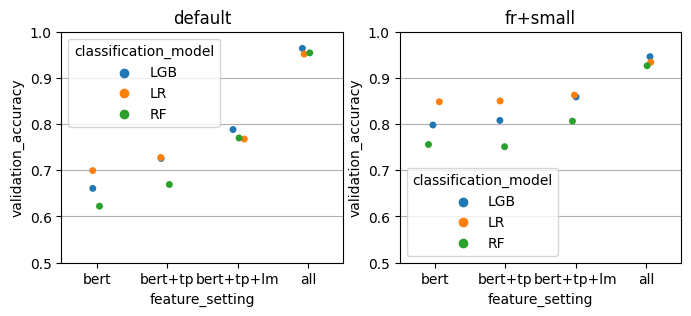

In [11]:
scatter_plot(
    df,
    COLUMNS_ORDER,
    ax_column="embeddings",
    x_column="feature_setting",
    color_column="classification_model",
    metric="validation_accuracy",
    ymin=0.5,
)

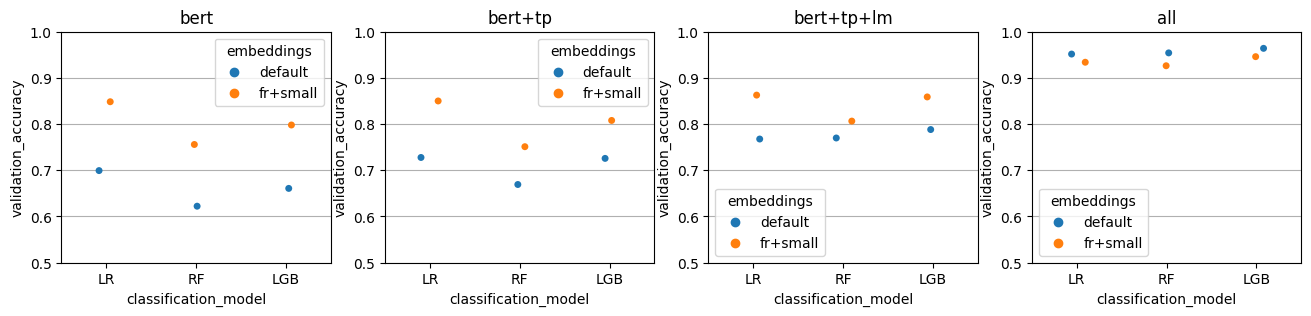

In [12]:
scatter_plot(
    df,
    COLUMNS_ORDER,
    ax_column="feature_setting",
    x_column="classification_model",
    color_column="embeddings",
    metric="validation_accuracy",
    ymin=0.5,
)

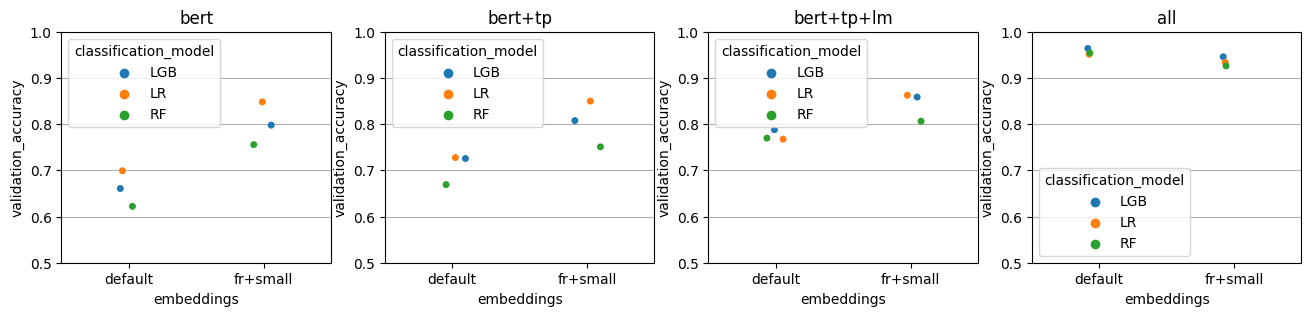

In [13]:
scatter_plot(
    df,
    COLUMNS_ORDER,
    ax_column="feature_setting",
    x_column="embeddings",
    color_column="classification_model",
    metric="validation_accuracy",
    ymin=0.5,
)

## Confusion matrix

In [14]:
df["classes_labels"] = df["classes_labels"].apply(lambda x: tuple(x))
assert (df.groupby("is_binary")["classes_labels"].nunique() == 1).all()

In [15]:
BINARY_CLASSES = df[df["is_binary"]].iloc[0]["classes_labels"]

In [16]:
groupby_column = "feature_setting"
cm_serie = (
    df[df.setting == "clean_vs_all"]
    .groupby(groupby_column)["validation_confusion_matrix"]
    .mean()
    .sort_index(key=COLUMNS_KEY[groupby_column])
)
cm_serie

feature_setting
bert          [[1414.5, 363.5], [594.6666666666666, 1183.333...
bert+tp       [[1465.8333333333333, 312.1666666666667], [558...
bert+tp+lm    [[1545.3333333333333, 232.66666666666666], [44...
all           [[1667.3333333333333, 110.66666666666667], [82...
Name: validation_confusion_matrix, dtype: object

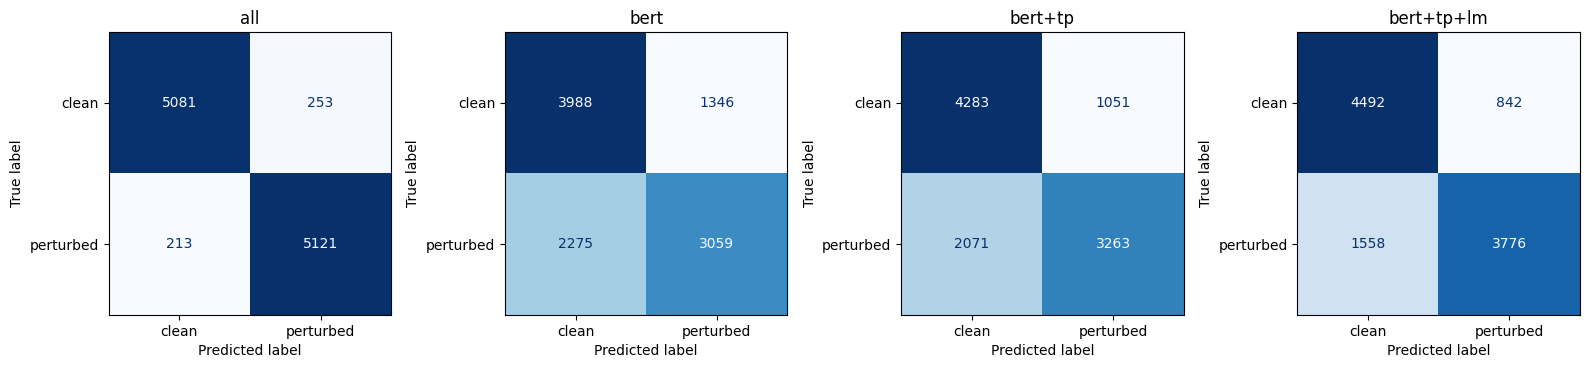

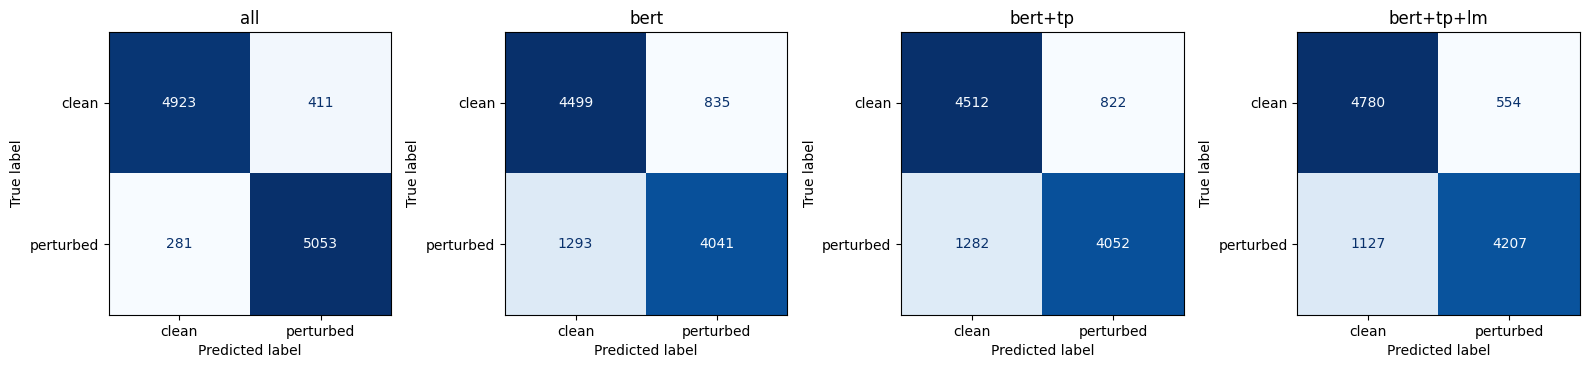

In [17]:
column1 = "embeddings"
column_groupby = "feature_setting"

for modality1 in COLUMNS_ORDER[column1]:
    cm_serie = (
        select_experiment(df, COLUMNS_ORDER, **{column1: modality1}, verbose=True)
        .groupby(column_groupby)["validation_confusion_matrix"]
        .sum()
    )
    plot_confusion_matrix_serie(cm_serie, binary_classes=BINARY_CLASSES)

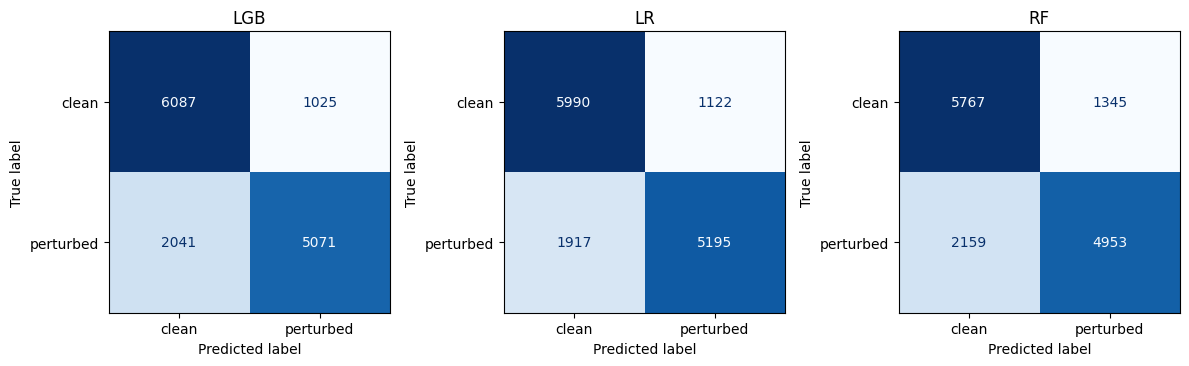

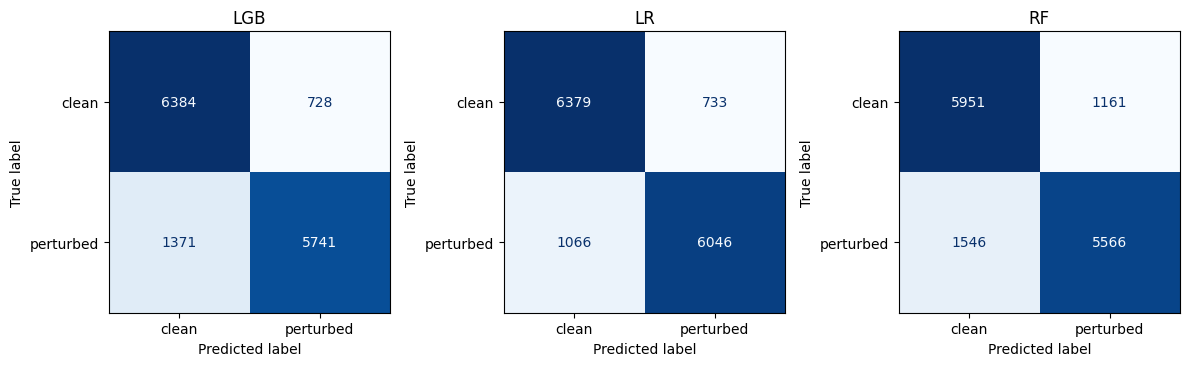

In [18]:
column1 = "embeddings"
column_groupby = "classification_model"

for modality1 in COLUMNS_ORDER[column1]:
    cm_serie = (
        select_experiment(df, COLUMNS_ORDER, **{column1: modality1}, verbose=True)
        .groupby(column_groupby)["validation_confusion_matrix"]
        .sum()
    )
    plot_confusion_matrix_serie(cm_serie, binary_classes=BINARY_CLASSES)

## Logistic regression coef

In [19]:
exp = select_experiment(
    df,
    COLUMNS_ORDER,
    embeddings="default",
    setting="clean_vs_all",
    classification_model="LR",
    feature_setting="all",
)

In [20]:
df_coef = pd.DataFrame(exp.coef)
for column in df_coef.columns:
    df_coef[column + "_abs"] = df_coef[column].abs()
df_coef.sort_values("perturbed_abs", ascending=False).head(25)

,perturbed,perturbed_abs
tm_activation_var_layer76_region3,0.358764,0.358764
lm_proba_var_region3,0.347249,0.347249
tm_gradient_quant1_layer42_region3,-0.343194,0.343194
tm_activation_mean_layer31_region0,0.315824,0.315824
tm_activation_mean_layer76_region3,0.299407,0.299407
tm_gradient_quant1_layer58_region3,-0.294766,0.294766
tm_activation_quant0_layer67_region3,0.284564,0.284564
tm_activation_quant0_layer76_region3,-0.281195,0.281195
tm_activation_quant1_layer5_region3,0.277418,0.277418
tm_activation_quant2_layer77_region1,0.277050,0.277050


## Latex

In [21]:
df_style = (
    select_experiment(
        df,
        COLUMNS_ORDER,
        classification_model="LR",
        metrics=True,
        split="validation",
    )
    .sort_values(by="validation_accuracy", ascending=False)
    .style.background_gradient(cmap=CMAP)
    .hide_index()
)
display(df_style)
# print(df_style.format(escape="latex", precision=3).to_latex(convert_css=True))

C:\Users\Baptiste\AppData\Local\Temp\ipykernel_37040\1228673565.py:7: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  ).hide_index()


embeddings,feature_setting,classification_model,validation_accuracy,validation_recall,validation_precision,validation_f1_score,validation_roc_auc
default,all,LR,0.951350,0.938133,0.963605,0.950698,0.951350
fr+small,all,LR,0.933633,0.920697,0.945150,0.932764,0.933633
fr+small,bert+tp+lm,LR,0.862486,0.834083,0.884317,0.858466,0.862486
fr+small,bert+tp,LR,0.849831,0.824522,0.868483,0.845932,0.849831
fr+small,bert,LR,0.848144,0.821147,0.868014,0.843931,0.848144
default,bert+tp+lm,LR,0.767435,0.699100,0.809772,0.750377,0.767435
default,bert+tp,LR,0.727503,0.655793,0.765594,0.706453,0.727503
default,bert,LR,0.699100,0.628796,0.731675,0.676346,0.699100


In [22]:
df_style = (
    select_experiment(
        df,
        COLUMNS_ORDER,
        classification_model="LR",
        metrics=True,
        split="validation",
    )
    .sort_values(by="validation_accuracy", ascending=False)[
        ["embeddings", "feature_setting", "classification_model", "validation_accuracy"]
    ]
    .style.hide_index()
)
display(df_style)
# print(df_style.format(escape="latex", precision=3).to_latex(convert_css=True))

C:\Users\Baptiste\AppData\Local\Temp\ipykernel_37040\2121643793.py:5: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  ).sort_values(by="validation_accuracy", ascending=False)[["embeddings", "feature_setting", "classification_model", "validation_accuracy"]].style.hide_index()


embeddings,feature_setting,classification_model,validation_accuracy
default,all,LR,0.951350
fr+small,all,LR,0.933633
fr+small,bert+tp+lm,LR,0.862486
fr+small,bert+tp,LR,0.849831
fr+small,bert,LR,0.848144
default,bert+tp+lm,LR,0.767435
default,bert+tp,LR,0.727503
default,bert,LR,0.699100


In [23]:
df_style = (
    select_experiment(
        df,
        COLUMNS_ORDER,
        # classification_model="LR",
        metrics=True,
        split="validation",
    )
    .sort_values(by="validation_accuracy", ascending=False)
    .style.background_gradient(cmap=CMAP)
    .hide_index()
)
display(df_style)
# print(df_style.format(escape="latex", precision=3).to_latex(convert_css=True))

C:\Users\Baptiste\AppData\Local\Temp\ipykernel_37040\384031992.py:7: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  ).hide_index()


embeddings,feature_setting,classification_model,validation_accuracy,validation_recall,validation_precision,validation_f1_score,validation_roc_auc
default,all,LGB,0.963723,0.972441,0.955777,0.964037,0.963723
default,all,RF,0.953881,0.969629,0.940022,0.954596,0.953881
default,all,LR,0.951350,0.938133,0.963605,0.950698,0.951350
fr+small,all,LGB,0.945726,0.958943,0.934247,0.946434,0.945726
fr+small,all,LR,0.933633,0.920697,0.945150,0.932764,0.933633
fr+small,all,RF,0.926040,0.962317,0.897221,0.928630,0.926040
fr+small,bert+tp+lm,LR,0.862486,0.834083,0.884317,0.858466,0.862486
fr+small,bert+tp+lm,LGB,0.858549,0.803150,0.903226,0.850253,0.858549
fr+small,bert+tp,LR,0.849831,0.824522,0.868483,0.845932,0.849831
fr+small,bert,LR,0.848144,0.821147,0.868014,0.843931,0.848144
